In [1]:
import sys
import pathlib
utils_path = pathlib.Path().absolute().parent.parent
sys.path.append(utils_path.__str__())

import utils
import plotly.io as pio
import utils.layout as lay
from utils.config import apikey
import pandas as pd
import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import plotly.graph_objects as go
from pmdarima.arima import auto_arima
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf  
from eodhd import APIClient
from sklearn.metrics import mean_squared_error

from utils.config import apikey
api = APIClient(apikey)

In [2]:
pio.templates.default = 'simple_white+blog_mra'

In [3]:
# Function to perform the Augmented Dickey-Fuller test
def adf_test(time_series):
    result = adfuller(time_series)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    if result[1] > 0.05:
        print("Series is non-stationary")
    else:
        print("Series is stationary")

In [9]:
# Fetch and preprocess data
unemployment_data = pd.DataFrame(api.get_macro_indicators_data("USA", "unemployment_total_percent"))[["Date", "Value"]]
unemployment_data = unemployment_data.set_index("Date").sort_index()
unemployment_data.index = pd.to_datetime(unemployment_data.index)
unemployment_data = unemployment_data.asfreq(freq='A')
unemployment_data.head()

,Value
Date,
1960-12-31,5.5
1961-12-31,6.7
1962-12-31,5.5
1963-12-31,5.7
1964-12-31,5.2


In [10]:
# Splitting the time series data
split_percentage = 0.9
split_index = int(len(unemployment_data) * split_percentage)
training_data = unemployment_data[:split_index]
test_data = unemployment_data[split_index:]

In [13]:
# Plotting the data
fig = go.Figure()
fig.add_trace(go.Scatter(x=training_data.index, y=training_data['Value'], name='Estimation'))
fig.add_trace(go.Scatter(x=test_data.index, y=test_data['Value'], name='Test'))
fig.update_layout(xaxis_title="Year", yaxis_title="Unemployment Rate (%)", title_text="Unemployment Rate - Annual")
fig.show()

In [12]:
# Perform ADF test on the training data
adf_test(training_data['Value'])

ADF Statistic: -3.527243
p-value: 0.007314
Critical Values:
	1%: -3.558
	5%: -2.917
	10%: -2.596
Series is stationary


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=159.530, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=156.939, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=154.878, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=157.531, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=156.544, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=156.306, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.62 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=152.879, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=154.546, Time=0.11 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=154.309, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=154.939, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.43 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.888 seconds
                               SARIMAX Results                                
Dep. Variable:               

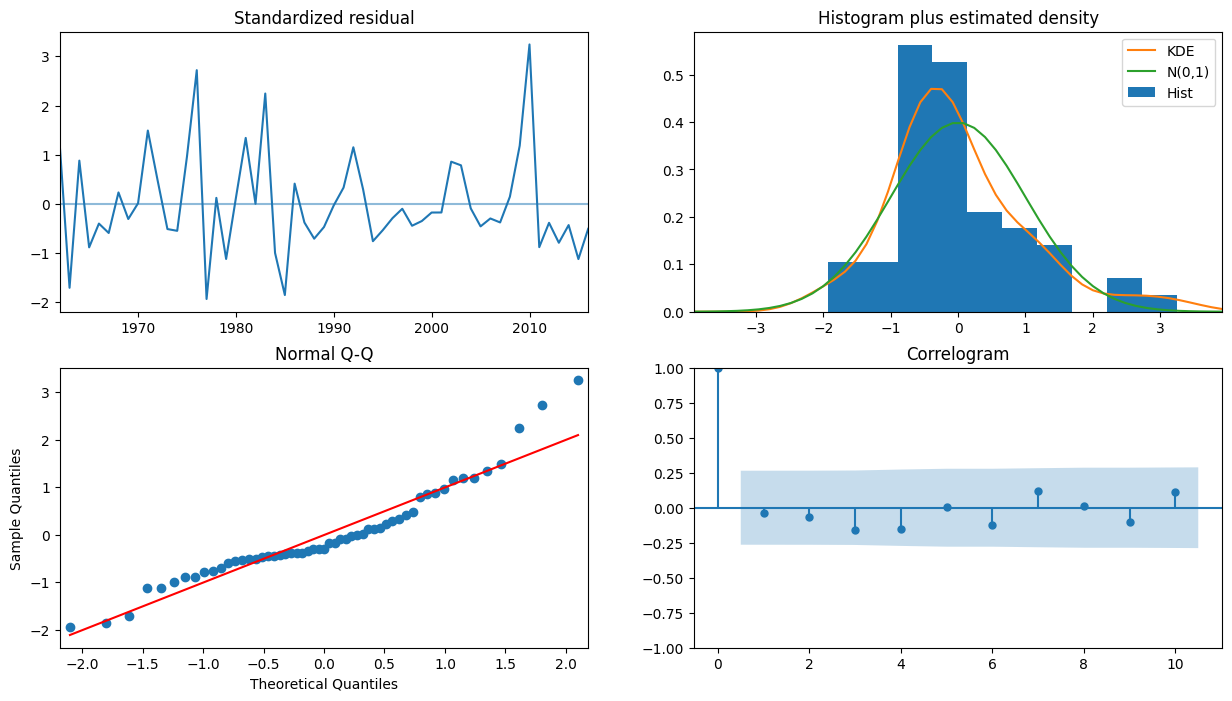

In [13]:
# Building and fitting the ARIMA model
model_autoARIMA = auto_arima(training_data, start_p=0, start_q=0,
                             test='adf', max_p=2, max_q=2, m=1,
                             d=None, seasonal=False, start_P=0, 
                             D=0, trace=True,
                             error_action='ignore',  
                             suppress_warnings=True, 
                             stepwise=True)

print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

                               SARIMAX Results                                
Dep. Variable:                 UnRate   No. Observations:                   56
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 -74.439
Date:                Tue, 09 Jan 2024   AIC                            152.879
Time:                        13:09:09   BIC                            156.894
Sample:                    12-31-1960   HQIC                           154.431
                         - 12-31-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.3960      0.120      3.313      0.001       0.162       0.630
sigma2         0.8745      0.134      6.516      0.000       0.611       1.138
Ljung-Box (L1) (Q):                   0.09   Jarque-

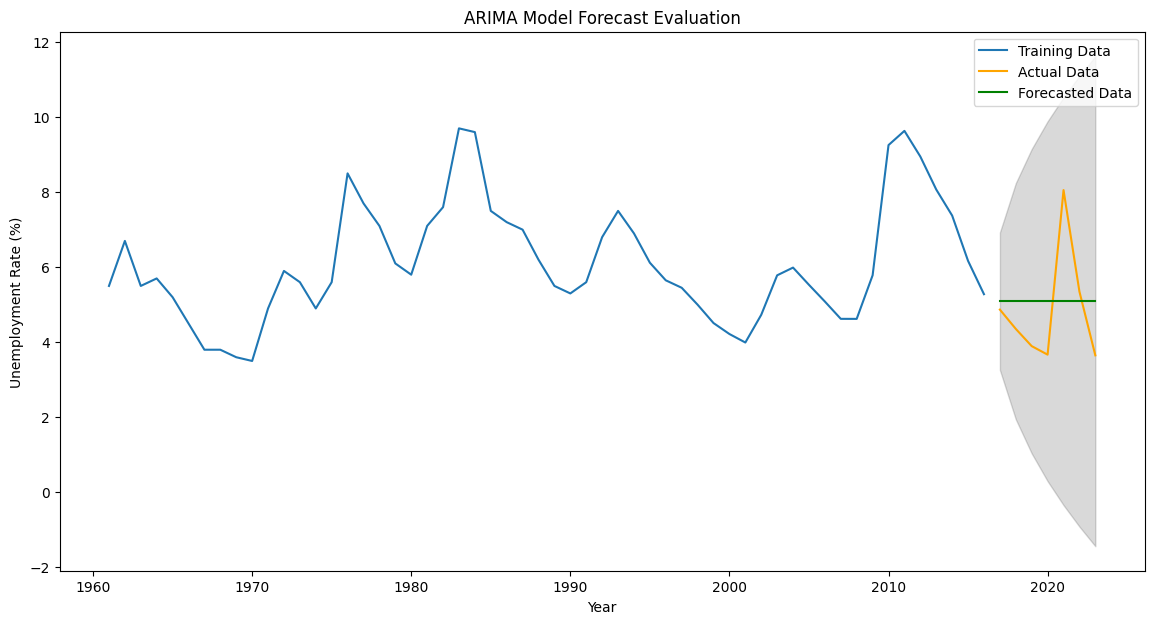

RMSE: 1.4626534461932772


In [14]:
# Fitting the ARIMA model
model = ARIMA(training_data, order=(0,1,1))  
fitted_model = model.fit()  
print(fitted_model.summary())

# Forecasting
forecast_steps = len(test_data)
forecast_results = fitted_model.get_forecast(steps=forecast_steps)
forecast_series = pd.Series(forecast_results.predicted_mean, index=test_data.index)

# Evaluating the forecast
mse = mean_squared_error(test_data, forecast_series)
rmse = mse**0.5

# Plotting the forecast results
plt.figure(figsize=(14,7))
plt.plot(training_data, label='Training Data')
plt.plot(test_data, label='Actual Data', color='orange')
plt.plot(forecast_series, label='Forecasted Data', color='green')
plt.fill_between(test_data.index, 
                 forecast_results.conf_int().iloc[:, 0], 
                 forecast_results.conf_int().iloc[:, 1], 
                 color='k', alpha=.15)
plt.title('ARIMA Model Forecast Evaluation')
plt.xlabel('Year')
plt.ylabel('Unemployment Rate (%)')
plt.legend()
plt.show()

print('RMSE:', rmse)